## Tricks of the trade in ML
In the lecture you talked about the main pillars of NN optimization: stochastic gradient descent and backpropagation. Unfortunatlly, these are insufficient to train accurate models as, e.g., here is no guarantee of reaching a global optimum. You therefore reviewed the leading methods for improving and stabilizing the training procedure via hyperparameters tunning.

In this notebook we demonstrate the ability of using these *tricks of the trade* to learn complex accurate mappings. We do this by considering the classification of spiral data.

We start with calling some useful libraries for mathematical opeartions (numpy, math), visualization (matpoltlib), and most importantly, neural networks (torch).

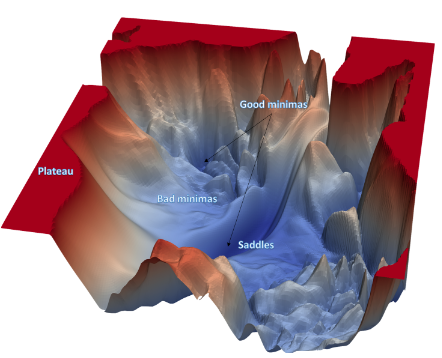

In [ ]:
import random
import torch
import numpy as np
from torch import nn, optim
import math
from IPython import display
import matplotlib.pyplot as plt
import copy
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

# Data Generation
First, we generate the data.
We consider two-dimensional data samples divided to $C=3$ different classes. Here the data from the $c$th class, $c\in \{0,1,2\}$, is generated via:
$${\bf y}_c[i] = i\cdot \left(\begin{array}{c} \sin(\frac{2\pi}{C}(2i+c)+ \mathcal{N}(0, \sigma^2)) \\ \cos(\frac{2\pi}{C}(2i+c)+ \mathcal{N}(0, \sigma^2) ) \end{array}\right) .$$

To understand what this data looks like, we generate some samples:

In [ ]:
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes

X = torch.zeros(N * C, D)
y = torch.zeros(N * C, dtype=torch.long)
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    # When c = 0 and t = 0: start of linspace
    # When c = 0 and t = 1: end of linpace
    # This inner_var is for the formula inside sin() and cos() like sin(inner_var) and cos(inner_Var)
    inner_var = torch.linspace(
        # When t = 0
        (2 * math.pi / C) * (c),
        # When t = 1
        (2 * math.pi / C) * (2 + c),
        N
    ) + torch.randn(N) * 0.2

    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((math.sin(inner_var[index]), math.cos(inner_var[index])))
        y[ix] = c
        index += 1

# Permute the data randomly
p = np.random.permutation(N * C)
X = X[p,:]
y = y[p]

print("Shapes:")
print("data X:", tuple(X.size()))
print("label y:", tuple(y.size()))

Shapes:
data X: (3000, 2)
label y: (3000,)


We have generated $1000$ samples from each label, i.e., a total of $T=3000$ data samples. Let's see what this data looks like:

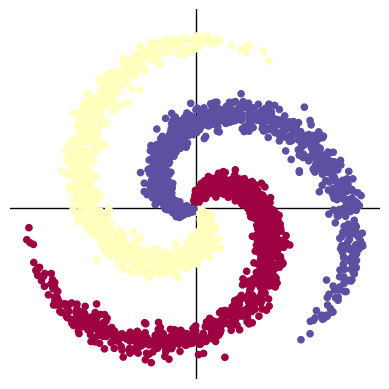

In [ ]:
def cartesian_coordinate_system():
    plt.axvline(0, color='0', lw=1, zorder=0)
    plt.axhline(0, color='0', lw=1, zorder=0)
    plt.axis('off')
    plt.axis('square')

def plot_data(X, y):
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    cartesian_coordinate_system()

# visualise the data
plot_data(X,y)

## Data Partition
As discussed in the lecture, to be able to monitor the learning procedure while being able to identify overfitting, it is
extremely common to divide the labeled data set $\mathcal{D} = \{\boldsymbol{x}_t, \boldsymbol{s}_t\}_{t=1}^{n_t}$ into training data and validation
data.

In [ ]:
TrainInput, TrainLabel, ValidInput, ValidLabel = X[:2500,:], y[:2500],X[2501:,:], y[2501:]

# Model Selection
Recall the neuron, which particularily cannot be tuned to carry out simple operations such as XOR computations, explaining the AI winter of the 1970’s. Nevertheless, deviating from the Boolean setting of the neuron and forms the multivariate non-binary perceptron, conmbined with non-linear activations, does the trick. This given rise to the importance in selecting the model arcitecture (parametrization) to suceed solving a given task.


## Linear Model
The first model we train is a linear classifier. We write the model as two linear layers to understand the power of non-linear activations, when we compare to a neural network in the sequel. Therefore, we wite the $2\times 3$ affine mapping as a concatanation of a $2\times 100$ mapping and a $100\times 3$ mapping.

Again, PyTorch provides a very simple interface to form a multi-layered model, using the *Sequential()* module.

In [ ]:
# each Linear module has a weight and bias
H = 100  # num_hidden_units
Linear_model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)

print(Linear_model)
print(Linear_model[0])
print(Linear_model[0].weight.shape)
print(Linear_model[0].weight.requires_grad)
print(Linear_model[0].weight.grad)

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=3, bias=True)
)
Linear(in_features=2, out_features=100, bias=True)
torch.Size([100, 2])
True
None


### Introducing `state_dict`

In [ ]:
print(type(Linear_model.state_dict()))
for k, v in Linear_model.state_dict().items():
  print(k, v.shape)

Linear_model_initial_weights = copy.deepcopy(Linear_model.state_dict())

<class 'collections.OrderedDict'>
0.weight torch.Size([100, 2])
0.bias torch.Size([100])
1.weight torch.Size([3, 100])
1.bias torch.Size([3])


**NOTE:** for a later usage, we kept the initial weights of the models. Since  `model.state_dict()` returns a reference to the state and not its copy, we used `deepcopy(model.state_dict())`; otherwise the model weights will keep getting updated by the subsequent training iterations. As a result, the intial model state will be the state of the final model.

## Neural Network
Next, we implement a neural network, by adding a non-linear ReLU activation operates on the output of the first hidden affine layer. So we have a network of the form:
$2\times 100$ -- ReLU -- $100 \times 3$.

In [ ]:
NN_model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C)
)
print(NN_model)
NN_model_initial_weights = copy.deepcopy(NN_model.state_dict())

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=3, bias=True)
)


# Training Algorithems
Now that we have generated data, and form two different parameterized models, we can train them to carry out classification, and keep the optimal one.


## Weights Initialization
The initial weights are the starting point from which the optimizer
begins its gradient-based journey over the high-dimensional loss surface. For highly non-convex surfaces, different initial weights may lead SGD to different local minima. Here, we use the defult PyTorch [setting](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).

In [ ]:
print(Linear_model[0].bias[:10])
print(NN_model[0].bias[:10])


tensor([-0.0348,  0.6200, -0.3920, -0.2360, -0.1963, -0.6847, -0.3259,  0.5594,
        -0.6836, -0.5936], grad_fn=<SliceBackward0>)
tensor([-0.0047, -0.0690, -0.1444, -0.4198, -0.1047, -0.6732, -0.3538,  0.0826,
        -0.1655,  0.4053], grad_fn=<SliceBackward0>)


**Accuracy:** So far we have quantify model performance via the loss function. Here, we will additionally measure the *accuracy*. While the loss measures the difference between the predicted and actual output, accuracy measures the number of correct predictions. We can now write the training function, and then train each model seperatly.

In [ ]:
minibatch_size = 500
n_epochs = 1000
def train_model(model, optimizer):

    train_acc, valid_acc = [], []

    # Training
    for t in range(n_epochs):
        # Divide data into mini batches
        p = np.random.permutation(len(TrainInput))
        train_data = TrainInput[p]
        train_label = TrainLabel[p]

        acc, Validacc = 0.0, 0.0

        for i in range(0, train_data.shape[0], minibatch_size):
          pred = model(train_data[i:i+minibatch_size])
          loss = criterion(pred, train_label[i:i+minibatch_size])
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        # Compute training accuracy
        score, predicted = torch.max(model(train_data), 1)
        acc = (train_label == predicted).sum().float() / len(train_label)


        # Compute the validation accuracy
        _, predicted = torch.max(model(ValidInput), 1)
        Validacc = (ValidLabel == predicted).sum().float() / len(ValidLabel)

        print("[EPOCH]: %i, [LOSS]: %.6f, [TRAIN ACCURACY]: %.3f, [VALID ACCURACY]: %.3f" % (t, loss.item(), acc, Validacc))
        display.clear_output(wait=True)


        # Save error on each epoch
        train_acc.append(acc)
        valid_acc.append(Validacc)

    return train_acc, valid_acc


Since we are dealing with a classification function, we use here the cross-entropy loss, i.e,
$$l_{\rm CE}(f,\boldsymbol{x},\boldsymbol{s}) =
-\sum_{k=1}^{K} \mathbb{1}_{\boldsymbol{s} = \boldsymbol{s}_k} \log f_k(\boldsymbol{x}),$$
where $\mathbb{1}_{(\cdot)}$ is the indicator function. PyTocrh built in `CrossEntropyLoss()` criterion already converts the model outputs into softmax values, so it effectively implies that the models have a **softmax output layer**. The optimizer we select is the SGD optimizer (and will later be compared to ADAM) with learning rate $\mu=10^{-3}$.

In [ ]:
# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply SGD for our parameter updates
learning_rate = 1e-03
Linear_model_optimizer = torch.optim.SGD(Linear_model.parameters(), lr=learning_rate)
NN_model_optimizer = torch.optim.SGD(NN_model.parameters(), lr=learning_rate)

In [ ]:
train_acc_Linear_model, valid_acc_Linear_model = train_model(Linear_model, Linear_model_optimizer)

[EPOCH]: 999, [LOSS]: 0.755038, [TRAIN ACCURACY]: 0.513, [VALID ACCURACY]: 0.497


In [ ]:
train_acc_NN_model, valid_acc_NN_model = train_model(NN_model, NN_model_optimizer)

[EPOCH]: 999, [LOSS]: 0.838830, [TRAIN ACCURACY]: 0.519, [VALID ACCURACY]: 0.501


Strage, No?

Having trained the models, the restriction to use linear model achieves around $50\%$ accuracy, as does the non-linearity of the neural network. This is better, though, than randomly choosing a label out of three possibilities.

We would expect to see that the NN model outperfoms its linear counterpart, due to its reacher strcuture. This reveals that the configuration of the optimizer and its setting really matters. In such a case, we would try to further improve the models, either by serching a better learning rate, or resorting to another optimizer, e.g, the Adam optmizer.

## Optimizing the learning rate
By the, supposedly, minor modification of the learning rate from $\mu=10^{-3}$ to $\mu=0.05$, we get ~$90\%$ accuracy for the NN model. **We are re-initializing the model weights to have similar strating point**.

In [ ]:
learning_rate = 0.05
Linear_model_optimizer.param_groups[0]['lr'] = learning_rate
NN_model_optimizer.param_groups[0]['lr'] = learning_rate

Linear_model.load_state_dict(Linear_model_initial_weights)
NN_model.load_state_dict(NN_model_initial_weights)

<All keys matched successfully>

In [ ]:
train_acc_Linear_model, valid_acc_Linear_model = train_model(Linear_model, Linear_model_optimizer)

[EPOCH]: 999, [LOSS]: 0.766311, [TRAIN ACCURACY]: 0.512, [VALID ACCURACY]: 0.493


In [ ]:
train_acc_NN_model, valid_acc_NN_model = train_model(NN_model, NN_model_optimizer)

[EPOCH]: 999, [LOSS]: 0.177622, [TRAIN ACCURACY]: 0.921, [VALID ACCURACY]: 0.920


## Optimizer Selection
Using the Adam optmizer, yeilds a further improvment for the NN model, **with half the amount of epochs**.

In [ ]:
# use Adam's defult learning_rate=0.001
Linear_model_optimizer = torch.optim.Adam(Linear_model.parameters())
NN_model_optimizer = torch.optim.Adam(NN_model.parameters())

Linear_model.load_state_dict(Linear_model_initial_weights)
NN_model.load_state_dict(NN_model_initial_weights)

n_epochs = 500

In [ ]:
len(NN_model_optimizer.param_groups)

1

In [ ]:
train_acc_Linear_model, valid_acc_Linear_model = train_model(Linear_model, Linear_model_optimizer)


[EPOCH]: 499, [LOSS]: 0.733514, [TRAIN ACCURACY]: 0.510, [VALID ACCURACY]: 0.495


In [ ]:
train_acc_NN_model, valid_acc_NN_model = train_model(NN_model, NN_model_optimizer)

[EPOCH]: 499, [LOSS]: 0.073476, [TRAIN ACCURACY]: 0.993, [VALID ACCURACY]: 0.990


## Monitoring the Learning Curves
The training curve provides an information regrading the suitability of the learning-rate and the mini-batch size, while the difference between the validation and training curves provides
an indication on the presence of overfitting.

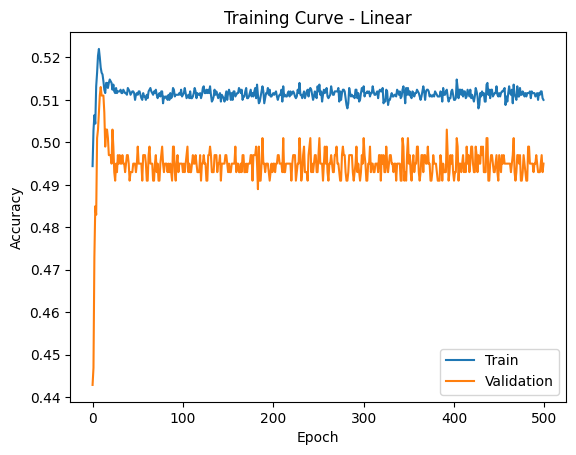

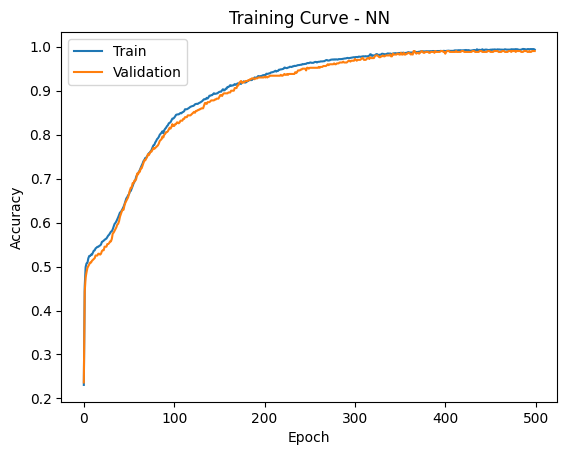

In [ ]:
# plotting
def plot_curves(train, valid, name):
  plt.title(f'Training Curve - {name}')
  plt.plot(range(len(train)), train, label="Train")
  plt.plot(range(len(valid)), valid, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

plot_curves(train_acc_Linear_model, valid_acc_Linear_model, "Linear")
plot_curves(train_acc_NN_model, valid_acc_NN_model, "NN")

 # Summery
 The division of the two-dimensional space illustrated next demonstrates the latter ability to capture complex classification tasks, in contrast to the linear model, which is incapable of capturing the spiral form of the data.

In [ ]:
def plot_model(X, y, model):
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)

    plt.subplot(1,3,1)
    plot_data(X, y)

    plt.subplot(1,3,2)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    cartesian_coordinate_system()

    plt.subplot(1,3,3)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)
    plt.show()


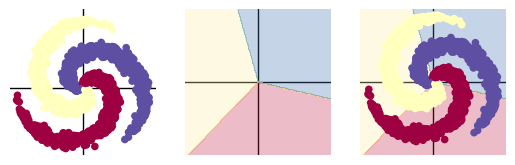

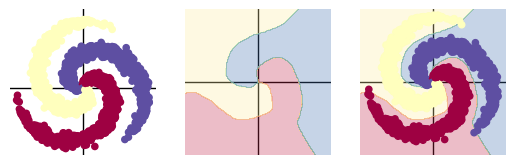

In [ ]:
# plot trained model
plot_model(X, y, Linear_model)
plot_model(X, y, NN_model)

The two-dimensional space illustration perfectly reflects both the almost 100% accuracy of the NN model, and the fact that there is no point in tyring to further imporve the linear model, as it is not possible to linearly classify spiral data.

Further reading can be found [here](https://colah.github.io/posts/2014-03-NN-Manifolds-Topology/).